In [1]:
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from src.microcircuit import *
from src.save_exp import *
import sys
# import pandas as pd
from scipy.stats import sem

plt.style.use('./matplotlib_style.mplstyle')
cm_to_inch = 1/2.54  # centimeters in inches
pagewidth = 17 # width in cm

#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport src.microcircuit

# Transfer of $\varphi'(u)$ using noise

## Test different activation functions and noise levels

In [3]:
def high_pass_filter(data, tau_hi):
    hpf_data = [data[0].copy()]
    
    # High-pass has the form d v_out = d v_in - dt/tau * v_out
    for i in range(len(data)-1):
        d_hpf_data = (data[i+1] - data[i]) - dt / tau_hi * hpf_data[-1]
        hpf_data.append(hpf_data[-1] + d_hpf_data)
        
    hpf_data = np.array(hpf_data)
        
    return hpf_data


def low_pass_filter(data, tau_lo):
    return data - high_pass_filter(data, tau_lo)

In [4]:
def calc_vals(activation, d_activation, dataset_size, noise_sigma, Tpres, dt, tau_noise):

    # generate clean data
    u_vals = np.linspace(-5, 5, int(dataset_size))
    u_vals_sorted = u_vals.copy()
    np.random.shuffle(u_vals)
    u_time_series = np.repeat(u_vals, int(Tpres / dt), axis=0)

    # correct derivative to compare to
    r_prime_vals = d_activation(u_vals)
    r_prime_vals_sorted = d_activation(u_vals_sorted)

    # add white noise
    u_noise_time_series = u_time_series + np.random.normal(0, noise_sigma, size=u_time_series.shape)

    # apply activation and hi-pass
    r_noise_time_series = activation(u_noise_time_series)
    r_hpf_time_series = high_pass_filter(r_noise_time_series, tau_noise)
    
    # take positive part
#     r_hpf_pos_time_series = np.abs(r_hpf_time_series)
    r_hpf_pos_time_series = relu(r_hpf_time_series)

#     # take mean over sample
    r_hpf_vals = r_hpf_pos_time_series.reshape(-1, int(Tpres / dt))
    r_hpf_vals = np.mean(r_hpf_vals, axis=1)
#     # take moving average
#     r_hpf_vals = moving_average(r_hpf_time_series, int(Tpres / dt))
    
    return u_time_series, u_noise_time_series, r_hpf_time_series, u_vals, r_hpf_vals, r_prime_vals, u_vals_sorted, r_prime_vals_sorted

In [5]:
dataset_size = 50

In [6]:
# all in units of ms
Tpres = 100.0
dt = 1e-2
tau_noise = 10 * dt

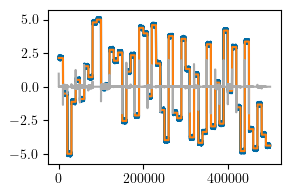

In [7]:
plt.figure()

u_time_series, u_noise_time_series, r_hpf_time_series, _, _, _, _, _ = calc_vals(tanh, d_tanh,
                                                 dataset_size, 0.05,
                                                 Tpres, dt, tau_noise)

plt.plot(u_noise_time_series)
plt.plot(u_time_series)
plt.plot(r_hpf_time_series)
# plt.xlim(2000, 2100)

plt.show()

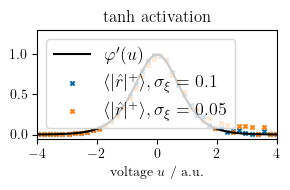

In [8]:
activation = tanh
d_activation = dict_d_activation[activation.__name__]

plt.figure()

for noise_sigma in [1e-1, 5e-2]:
    _, _, _, u_vals, r_hpf_vals, r_prime_vals, u_vals_sorted, r_prime_vals_sorted = calc_vals(activation, d_activation,
                                                 dataset_size, noise_sigma,
                                                 Tpres, dt, tau_noise)
#     norm = noise_sigma / np.sqrt(2/np.pi)
    norm = np.max(r_hpf_vals) / np.max(r_prime_vals_sorted)
    plt.scatter(u_vals, r_hpf_vals / norm, label='$\\langle |\\hat{r}|^+ \\rangle, \\sigma_\\xi = $ ' + str(noise_sigma), marker='x')

plt.plot(u_vals_sorted, r_prime_vals_sorted, label='$\\varphi\'(u)$', c='black')

plt.xlabel('voltage $u$ / a.u.')

plt.title(str(activation.__name__) + ' activation')
plt.xlim(-4, 4)
plt.ylim(-.05, 1.3)
plt.legend(prop={'size': 13})
plt.tight_layout()
plt.savefig("varphi_prime_transfer/" + str(activation.__name__) + " activation.pdf",bbox_inches='tight', dpi=400)
plt.savefig("varphi_prime_transfer/" + str(activation.__name__) + " activation.png",bbox_inches='tight', dpi=400)
plt.show()

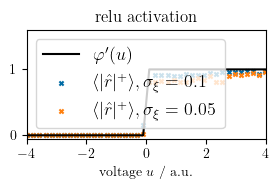

In [9]:
activation = relu
d_activation = dict_d_activation[activation.__name__]

plt.figure()

for noise_sigma in [1e-1, 5e-2]:
    _, _, _, u_vals, r_hpf_vals, r_prime_vals, u_vals_sorted, r_prime_vals_sorted = calc_vals(activation, d_activation,
                                                 dataset_size, noise_sigma,
                                                 Tpres, dt, tau_noise)
#     norm = noise_sigma / np.sqrt(2/np.pi)
    norm = np.max(r_hpf_vals) / np.max(r_prime_vals_sorted)
    plt.scatter(u_vals, r_hpf_vals / norm, label='$\\langle |\\hat{r}|^+ \\rangle, \\sigma_\\xi = $ ' + str(noise_sigma), marker='x')

plt.plot(u_vals_sorted, r_prime_vals_sorted, label='$\\varphi\'(u)$', c='black')

plt.xlabel('voltage $u$ / a.u.')

plt.title(str(activation.__name__) + ' activation')
plt.xlim(-4, 4)
plt.ylim(-.05, 1.6)
plt.legend(prop={'size': 13})
plt.tight_layout()
plt.savefig("varphi_prime_transfer/" + str(activation.__name__) + " activation.pdf",bbox_inches='tight', dpi=400)
plt.savefig("varphi_prime_transfer/" + str(activation.__name__) + " activation.png",bbox_inches='tight', dpi=400)
plt.show()

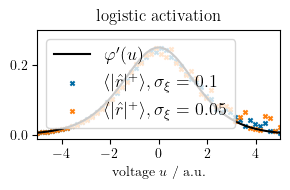

In [10]:
activation = logistic
d_activation = dict_d_activation[activation.__name__]

plt.figure()

for noise_sigma in [1e-1, 5e-2]:
    _, _, _, u_vals, r_hpf_vals, r_prime_vals, u_vals_sorted, r_prime_vals_sorted = calc_vals(activation, d_activation,
                                                 dataset_size, noise_sigma,
                                                 Tpres, dt, tau_noise)
#     norm = noise_sigma / np.sqrt(2/np.pi)
    norm = np.max(r_hpf_vals) / np.max(r_prime_vals_sorted)
    plt.scatter(u_vals, r_hpf_vals / norm, label='$\\langle |\\hat{r}|^+ \\rangle, \\sigma_\\xi = $ ' + str(noise_sigma), marker='x')

plt.plot(u_vals_sorted, r_prime_vals_sorted, label='$\\varphi\'(u)$', c='black')

plt.xlabel('voltage $u$ / a.u.')

plt.title(str(activation.__name__) + ' activation')
plt.xlim(-5, 5)
plt.ylim(-.01, 0.3)
plt.legend(prop={'size': 13})
plt.tight_layout()
plt.savefig("varphi_prime_transfer/" + str(activation.__name__) + " activation.pdf",bbox_inches='tight', dpi=400)
plt.savefig("varphi_prime_transfer/" + str(activation.__name__) + " activation.png",bbox_inches='tight', dpi=400)
plt.show()

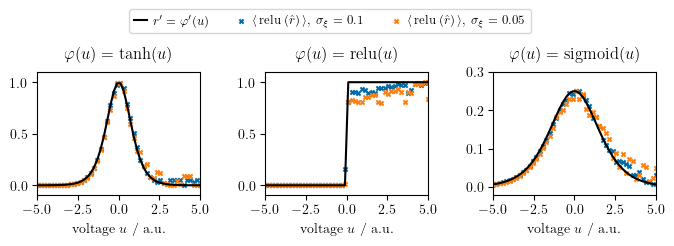

In [22]:
# all together now (all together)

fig, axes = plt.subplots(figsize=(pagewidth*cm_to_inch*1.2, pagewidth*cm_to_inch/3), ncols=3, gridspec_kw={'width_ratios': [1, 1, 1]})

activation_list = [tanh, relu, logistic]
activation_name_list = ['tanh', 'relu', 'sigmoid']

for i, activation in enumerate(activation_list):
    
    ax = axes[i]

    d_activation = dict_d_activation[activation.__name__]


    for noise_sigma in [1e-1, 5e-2]:
        _, _, _, u_vals, r_hpf_vals, r_prime_vals, u_vals_sorted, r_prime_vals_sorted = calc_vals(activation, d_activation,
                                                     dataset_size, noise_sigma,
                                                     Tpres, dt, tau_noise)
    #     norm = noise_sigma / np.sqrt(2/np.pi)
        norm = np.max(r_hpf_vals) / np.max(r_prime_vals_sorted)
        ax.scatter(u_vals, r_hpf_vals / norm, label='$\\langle \,\\textrm{relu} \;( \\hat{r}) \,\\rangle, \; \\sigma_\\xi = $ ' + str(noise_sigma), marker='x')

    ax.plot(u_vals_sorted, r_prime_vals_sorted, label='$r\' = \\varphi\'(u)$', c='black')

    ax.set_xlabel('voltage $u$ / a.u.')

    ax.set_title('$\\varphi(u) = $ ' + activation_name_list[i] + '$(u)$', pad=10)
    ax.set_xlim(-5, 5)
    ax.set_xticks([-5, -2.5, 0, 2.5, 5])

axes[0].set_ylim(-.09, 1.1)
axes[1].set_ylim(-.09, 1.1)
axes[2].set_ylim(-0.02, 0.3)
    
l = plt.legend(prop={'size': 9}, loc='upper center', handlelength=1, ncol=3, bbox_to_anchor=(-1,1.56), handletextpad=0.5, scatterpoints=1, scatteryoffsets=[0.4])
for t in l.get_texts(): t.set_va('baseline')
    
plt.subplots_adjust(left = 0.2, top = 0.8, right = 0.97, bottom = 0.25, hspace = 0.3, wspace = 0.4)
plt.savefig("varphi_prime_transfer/activation.pdf",bbox_inches='tight')

plt.show()
